In [1]:
%matplotlib notebook
import os
import numpy as np
import tensorflow as tf
from gf321_utils import bvh_utils
from gf321_utils import marker_utils
from gf321_utils import plot_utils

print (tf.__version__)

2.3.0


In [2]:
def corrupt(markers, occlude_std=0.1, shift_std=0.1, max_shift=500):
    '''
    Corruption function following Holden's corruption function.
    
    Expects input markers to have shape (frame_num, marker_num, 3)
    NB markers must be in a 'local' frame
    
    Reads markers and outputes markers with noise(shift) and occlusion(sent to origin)
    Using the default settings from Holden noting that max_shift = 'beta' = 50cm = 500(mm)
    ''' 
    
    frame_num = markers.shape[0]
    marker_num = markers.shape[1]
    
    #Sample probabilities at which to occlude/shift
    occlude_prob = np.random.normal(0, occlude_std, frame_num)
    shift_prob = np.random.normal(0, shift_std, frame_num)
    
    #Sample using clipped probabilities, and reshape appropriately
    occlusions = np.zeros((frame_num,marker_num))
    for fr in range(frame_num):
        occlusions[fr] = np.random.binomial(1, min(abs(occlude_prob[fr]), 2*occlude_std), marker_num)
    occlusions = occlusions.reshape((frame_num, marker_num))
    
    shifts = np.zeros((frame_num,marker_num))
    for fr in range(frame_num):
        shifts[fr] = np.random.binomial(1, min(abs(shift_prob[fr]), 2*shift_std), marker_num)
    shifts = shifts.reshape((frame_num, marker_num))
    
    #Sample the magnitude by which to shift each marker
    shift_mags = np.random.uniform(-max_shift, max_shift, frame_num*marker_num*3)
    shift_mags = shift_mags.reshape((frame_num, marker_num, 3))
    
    #Shift markers by shifting markers by sampled shift magnitude if the relevant entry in shifts is 1
    markers = markers + np.einsum('ij,ijk->ijk', shifts, shift_mags)
    #Occlude markers by sending occluded markers to origin
    markers = np.einsum('ijk,ij->ijk', markers, 1 - occlusions)
    
    return markers

In [3]:
class DogDenoiser():

    def __init__(self):
 
        #Parameters for reading data from file.
        #Ensure these are set properly
        self.data_filepath = 'neural_lbs_data/'
        self.joints_filename = 'all_joints_aug.npy'
        self.markers_filename = 'all_markers_aug.npy'

        #Parameters for neural net
        self.l2_regu = 0.01
        self.layer_num = 5 #hidden layer number
        self.unit_num = 128 #number of units in a hidden layer
        self.epochs = 10
        self.training_split = 0.8 #Splits data into training and validation
        self.tolerance = 1e-6 #tolerance for clipping zeros in standard deviation calculations
        
        #Parameters for data generation
        self.noisy_copies = 10
    
    
    
    def corrupt(self, markers, occlude_std=0.1, shift_std=0.1, max_shift=500):
        '''
        Corruption function following Holden's corruption function.

        Expects input markers to have shape (frame_num, marker_num, 3)
        NB markers must be in a 'local' frame

        Reads markers and outputes markers with noise(shift) and occlusion(sent to origin)
        Using the default settings from Holden noting that max_shift = 'beta' = 50cm = 500(mm)
        ''' 

        frame_num = markers.shape[0]
        marker_num = markers.shape[1]

        #Sample probabilities at which to occlude/shift
        occlude_prob = np.random.normal(0, occlude_std, frame_num)
        shift_prob = np.random.normal(0, shift_std, frame_num)

        #Sample using clipped probabilities, and reshape appropriately
        occlusions = np.zeros((frame_num,marker_num))
        for fr in range(frame_num):
            occlusions[fr] = np.random.binomial(1, min(abs(occlude_prob[fr]), 2*occlude_std), marker_num)
        occlusions = occlusions.reshape((frame_num, marker_num))

        shifts = np.zeros((frame_num,marker_num))
        for fr in range(frame_num):
            shifts[fr] = np.random.binomial(1, min(abs(shift_prob[fr]), 2*shift_std), marker_num)
        shifts = shifts.reshape((frame_num, marker_num))

        #Sample the magnitude by which to shift each marker
        shift_mags = np.random.uniform(-max_shift, max_shift, frame_num*marker_num*3)
        shift_mags = shift_mags.reshape((frame_num, marker_num, 3))

        #Shift markers by shifting markers by sampled shift magnitude if the relevant entry in shifts is 1
        markers = markers + np.einsum('ij,ijk->ijk', shifts, shift_mags)
        #Occlude markers by sending occluded markers to origin
        markers = np.einsum('ijk,ij->ijk', markers, 1 - occlusions)

        return markers



    def load_tr_data(self):
        '''
        Assumes input of mirrored (balanced) global (not local) data
        Inputs should be an array of joints of shape (frame_num, joint_num, 3, 4)
        and markers of shape (frame_num, marker_num, 3).
        Joints and markers should be paired (representing the same motion) 
        Inputs can be global as they are made local here

        Reads from npy files the joint and marker data, so needs to be set up properly in __init__
        '''

        #Load npy files containing joint and marker data
        if os.path.isfile(self.data_filepath + self.joints_filename):
            self.joints = np.load(self.data_filepath + self.joints_filename)
        else: raise Exception('joint npy file not found')
        if os.path.isfile(self.data_filepath + self.markers_filename):
            self.markers = np.load(self.data_filepath + self.markers_filename)
        else: raise Exception('marker npy file not found')

        #Create useful info for later
        self.frame_num = self.joints.shape[0]
        self.marker_num = self.markers.shape[1]       
        self.joint_num = self.joints.shape[1]
        assert self.markers.shape[0] == self.frame_num #check

        #Make local
        self.joints_loc = bvh_utils.make_joints_local(self.joints)
        self.root_tfs = bvh_utils.create_local_tfs_root(self.joints)
        self.markers_loc = marker_utils.make_markers_local(self.markers, self.root_tfs)
        
        ############### NB MIGHT MOVE BEFORE LOCALITY TO ALLOW FOR ZERO STYLE OCCLUSIONS OF GLOBAL DATA
        
        #Create noisy copies of markers. We name the joints file in a similar way for consistency.
        self.markers_loc_noise = np.array(self.markers_loc)
        self.joints_loc_noise = np.array(self.joints_loc)

        for c in range(self.noisy_copies):
            self.markers_loc_noise = np.append(self.markers_loc_noise, self.corrupt(self.markers_loc), axis=0)
            self.joints_loc_noise = np.append(self.joints_loc_noise, self.joints_loc, axis=0)
        print(self.joints_loc_noise.shape)
        
        
        #Collect means and stds
        self.joint_means = self.joints_loc_noise.mean(axis=0)
        self.joint_stds = self.joints_loc_noise.std(axis=0)
        self.marker_means = self.markers_loc_noise.mean(axis=0)
        self.marker_stds = self.markers_loc_noise.std(axis=0)
        
        #Make normalised data...
        self.markers_loc_n = np.zeros(self.markers_loc_noise.shape)
        self.joints_loc_n = np.zeros(self.joints_loc_noise.shape)
        self.markers_loc_n = (self.markers_loc_noise - self.marker_means)/self.marker_stds 
        #...via the mask
        mask = np.array(abs(self.joint_stds)<1e-6).nonzero()
        self.joint_stds[mask] = 1 #the trick
        self.joints_loc_n = (self.joints_loc_noise - self.joint_means) /self.joint_stds

        #Shuffle loc by creating shuffled indices to shuffle with
        shuffler = np.random.shuffle(np.arange(self.frame_num)) 
        self.joints_loc_n[:] = self.joints_loc_n[shuffler]
        self.markers_loc_n[:] = self.markers_loc_n[shuffler] 
        
        #Create training data
        self.split_tr = int(self.training_split * self.frame_num)
        self.markers_loc_tr = self.markers_loc_n[:self.split_tr,:]
        self.joints_loc_tr = self.joints_loc_n[:self.split_tr,:,:,:]
        #Create validation data
        self.markers_loc_val = self.markers_loc_n[self.split_tr:,:]
        self.joints_loc_val = self.joints_loc_n[self.split_tr:,:,:,:]
        
        #Create shapes for the network
        self.input_shape = (self.marker_num, 3)
        self.input_num = 3 * self.marker_num
        self.output_shape = (self.joint_num,3,4)
        self.output_num = 12 * self.joint_num

    
    
    def compile_net(self):
        
        tf.keras.backend.clear_session() #reset graph
        
        #Build net
        inputs = tf.keras.layers.Input(shape = self.input_shape)
        inputs_flat = tf.keras.layers.Flatten()(inputs)
        
        #First layer
        x = tf.keras.layers.Dense(self.unit_num, activation='relu')(inputs_flat)

        #Residual blocks; layer_num many
        for ind in range(self.layer_num):
            y = tf.keras.layers.Dense(self.unit_num, activation='relu')(x) 
            x = tf.keras.layers.Add()([x, y])  # skip connection
            x= tf.keras.layers.ReLU()(x)       

        #Last layer, linear activation for predictions
        outputs = tf.keras.layers.Dense(self.output_num)(x)
        print(outputs.shape)
        # ------------------------------------------------------

        #Define model
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        #Compile model
        self.model.compile(optimizer='adagrad', loss='mse')
        
        
    def fit(self, verbosity=1):
        
        #Train model with training data
        self.model.fit(self.markers_loc_tr, self.joints_loc_tr.reshape(self.joints_loc_tr.shape[0],43*3*4),
            validation_data=(self.markers_loc_val, self.joints_loc_val.reshape(self.joints_loc_val.shape[0],43*3*4)), verbose=verbosity, 
            batch_size=2, epochs=self.epochs)

In [4]:
nn = DogDenoiser()
nn.load_tr_data()

(44572, 43, 3, 4)


In [5]:
nn.markers_loc_tr.shape

(3241, 64, 3)

In [6]:
nn.compile_net()
nn.fit()

(None, 516)
Epoch 1/10


InternalError:  Blas GEMM launch failed : a.shape=(2, 192), b.shape=(192, 2048), m=2, n=2048, k=192
	 [[node functional_1/dense/MatMul (defined at <ipython-input-3-954ca05f015e>:177) ]] [Op:__inference_train_function_952]

Function call stack:
train_function


minmaxs are:  -374.22000392024165 254.6014178751484 -432.94745778201604 614.3980017996769 -591.1484151353819 105.70432751752615


<IPython.core.display.Javascript object>


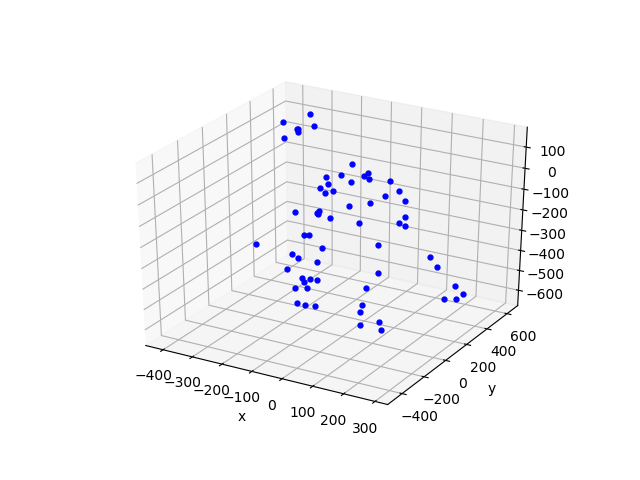

minmaxs are:  -467.8833727967758 253.98338569323323 -447.0702916858876 598.2855663048969 -601.3434412629449 91.6418599020343


<IPython.core.display.Javascript object>


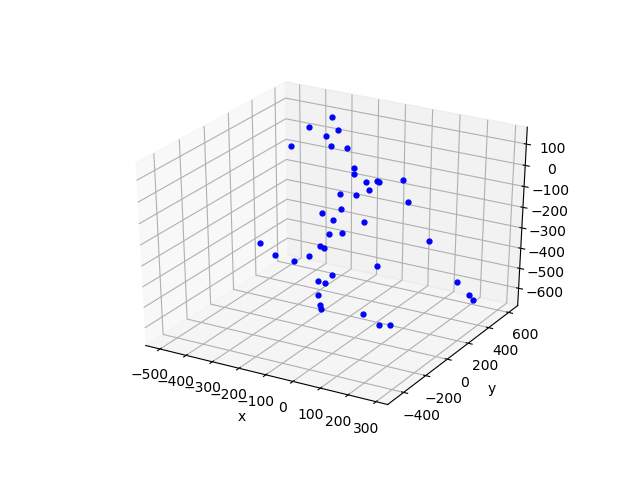

In [38]:
fr = 0
plot_utils.plot(nn.markers_loc_noise,fr)
plot_utils.plot(nn.joints_loc_noise[:,:,:,3],fr)

In [70]:
nn.compile_net()

ValueError: Input 0 of layer flatten is incompatible with the layer: its rank is undefined, but the layer requires a defined rank.